### Creating MFCC coeff and saving as a JSON

In [ ]:
import librosa
import math
import os

In [ ]:
SAMPLE_RATE = 22050 # STANDARD CONSUMER GRADE SAMPLE RATE

def save_mfcc(dataset_path,
              json_path,
              ignore = [],
              n_mfcc = 13,
              n_fft = 2048,
              hop_length = 512,
              num_segments = 10):
    """
    dataset_path: location of the dataset typically folder
    json_path: location where to save output json file
    n_mfcc: number of mfcc coffienant
    n_fft: number of fourier transform [ HAVE TO CHECK ]
    hop_length: length of single segment
    num_segment: total number of segment
    """

    data = {
        "mapping": [],
        "labels": [],
        "mfcc": [],
    }
    """
    mapping : Name of the composers
            : ["Morzart", "Beethovan", "Bach", ...]
    mfcc    : mfcc coff value in the 13(default) columned array,
            : [[...], [...], [...]]
    labels  : index of mapped composers
    """

    # loop in the dataset directory expect ignored root directory
    for idx, (root, dirs, files) in enumerate(os.walk(dataset_path)):

        if not root in ignore:
            composer = root.split("/")[-1]
            data["mapping"].append(composer)
            print(composer)

            for file in files:
                print(f"processing: {idx}. {composer} -> {file}")

                file_path = os.path.join(root, file)
                
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                duration = librosa.get_duration(signal, sr=SAMPLE_RATE)
                
                # full SAMPLE RATE of the track
                SAMPLES_PER_TRACK = SAMPLE_RATE * duration
                # number of segments in the track
                num_samples_per_segment = SAMPLES_PER_TRACK // num_segments

                # expected mfcc size for a segment
                expected_num_mfcc_vector_per_segment = math.ceil(num_samples_per_segment / hop_length)
                """
                This is required to eliminate those last segment of the
                track which are sorter then the required length
                """

                for s in range(num_segments):
                    start_sample = int(num_samples_per_segment * s)
                    finish_sample = int(start_sample + num_samples_per_segment)

                    # getting mfcc vector
                    mfcc = librosa.feature.mfcc(
                        signal[start_sample:finish_sample],
                        sr=sr,
                        n_fft=n_fft,
                        n_mfcc=n_mfcc,
                        hop_length=hop_length
                    )

                    mfcc = mfcc.T

                    if len(mfcc) == expected_num_mfcc_vector_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append((idx - 1))

                        print(f"{file}, segment: {s}")
    return data

In [ ]:
path = "/content/drive/MyDrive/MLProject/Dataset/"
ignore = ['/content/drive/MyDrive/MLProject/Dataset/', '/content/drive/MyDrive/MLProject/Dataset/zip', '/content/drive/MyDrive/MLProject/Dataset/zip/.ipynb_checkpoints']
json_path = '.'

data = save_mfcc(path, json_path, ignore)

In [ ]:
import json
with open("/content/drive/MyDrive/MLProject/Dataset/mfcc.json", "w") as file:
    json.dump(data, file, indent=4)

### Converting JSON to CSV
This is for simplicity

In [ ]:
import csv
import json

with open("/content/drive/MyDrive/MLProject/Dataset/mfcc.json", 'r') as file:
    json_data = json.load(file)

f_name = "/content/drive/MyDrive/MLProject/Dataset/mfcc.csv"

with open(f_name, 'w') as file:
    csv_file = csv.writer(file)
    csv_file.writerow(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "Composer"])

    for mfccs, label in zip(json_data['mfcc'], json_data['labels']):
        for idx, mfcc in enumerate(mfccs):
            print(f"---> Processing {idx} out of {len(mfccs)} mfccs for label {label}")
            csv_file.writerow([*mfcc, label])

### Spliting into Train and test

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
Model_DIR = "./drive/MyDrive/MLProject/Dataset/Models/"

In [ ]:
"""
>>> df = df.sample(frac=1) # frac is the fraction of dataset to be shuffled
"""

# Shuffled dataset
dataset = pd.read_csv("./drive/MyDrive/MLProject/Dataset/mfcc.csv")
dataset.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,Composer
0,1357448,-415.410004,147.368835,-5.781612,21.989471,10.195210,0.542820,-5.302103,5.939585,-5.105073,0.291927,-10.004902,-7.887849,-5.491504,5
1,148358,-332.414276,205.064697,27.147282,-26.302361,7.589743,7.412755,-19.591148,-20.049440,-8.548311,-7.312052,-4.859299,-1.658871,-6.918889,1
2,580860,-318.319275,135.326385,-13.443801,39.738213,8.758698,-13.666842,-7.626642,5.004135,-7.694477,0.389290,-13.829698,-0.894667,-5.064682,2
3,1386460,-282.813904,155.100281,-37.487755,7.327016,2.798068,-12.152862,-17.902344,-12.345676,-12.618148,-13.635829,-0.488468,0.999244,-7.956593,6
4,87388,-272.397858,220.498383,-18.909224,18.952602,14.201347,-10.364710,-12.911034,2.939507,7.245453,-3.308702,-9.361172,-11.794576,-13.272887,0


In [ ]:
print("Number of rows: %d" % len(dataset))

Number of rows: 1397380


In [ ]:
X = dataset.drop(["Unnamed: 0", "Composer"], axis=1)
Y = dataset.Composer

In [ ]:
from sklearn.model_selection import train_test_split

# what is the meaning of life the universe and everything?
# its 42 
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, 
    random_state=42, 
    train_size=0.8 # 80% train dataset
)

print(f"x_train.shape: {x_train.shape},\t x_test.shape: {x_test.shape}")
print(f"y_train.shape: {y_train.shape},\t y_test.shape: {y_test.shape}")

x_train.shape: (1117904, 13),	 x_test.shape: (279476, 13)
y_train.shape: (1117904,),	 y_test.shape: (279476,)


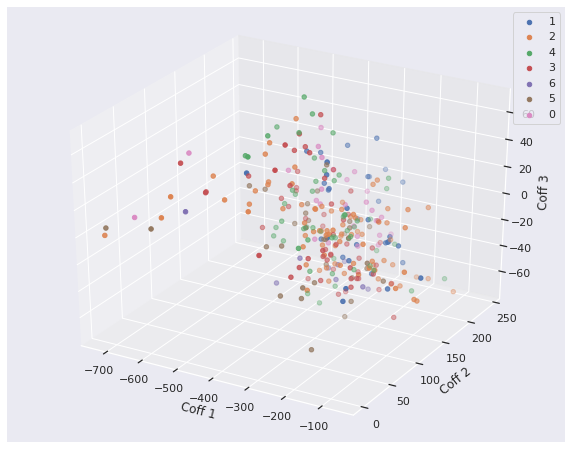

In [ ]:
# 3d plot of the first 300 values in dataset using first 3 mfcc coff

# Shuffling dataset
dummy_data = dataset.sample(frac=1)[:300]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for s in dummy_data.Composer.unique():
    ax.scatter(
        dummy_data['1'] [ dummy_data.Composer == s ],
        dummy_data['2'] [ dummy_data.Composer == s ],
        dummy_data['3'] [ dummy_data.Composer == s ],
        label = s
    )

ax.set_xlabel("Coff 1")
ax.set_ylabel("Coff 2")
ax.set_zlabel("Coff 3")
    
ax.legend()
fig.savefig('plot.png')


# Using SKLearn

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
"""
As dataset is very large, so we can standardize the
data set with StandardScale

z = (x - u) / s
z = after standardising
x = value
u = mean of the dataset
s = standard diviation of the dataset
"""
from sklearn.preprocessing import StandardScaler

# ovr is one vs rest
LR_pipeline = make_pipeline(StandardScaler(), LogisticRegression(multi_class="ovr"))
LR_pipeline.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(multi_class='ovr'))])

In [ ]:
# Predictions
LR_y_pred = LR_pipeline.predict(x_test)
LR_y_train_pred = LR_pipeline.predict(x_train)

In [ ]:
# calculating other require values
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix

LR_test_r2 = r2_score(y_test, LR_y_pred)
LR_train_r2 = r2_score(y_train, LR_y_train_pred)

LR_test_mse = mean_squared_error(y_test, LR_y_pred)
LR_train_mse = mean_squared_error(y_train, LR_y_train_pred)

LR_test_accuracy = accuracy_score(y_test, LR_y_pred)
LR_train_accuracy = accuracy_score(y_train, LR_y_train_pred)

print("Test r2_score %.2f" % LR_test_r2)
print("Train r2_score %.2f" % LR_train_r2)

print("\nTest mean squared error %.2f" % LR_test_mse)
print("Train mean squared error %.2f" % LR_train_mse)

print("\nTest accuracy score %.2f" % LR_test_accuracy)
print("Train accuracy score %.2f" % LR_train_accuracy)

Test r2_score -0.07
Train r2_score -0.08

Test mean squared error 2.48
Train mean squared error 2.48

Test accuracy score 0.44
Train accuracy score 0.44


In [ ]:
print("For test dataset")
print(classification_report(y_test, LR_y_pred))

print("\nFor train dataset")
print(classification_report(y_train, LR_y_train_pred))

For test dataset
              precision    recall  f1-score   support

           0       0.45      0.26      0.33     23733
           1       0.44      0.37      0.40     42661
           2       0.42      0.42      0.42     62796
           3       0.43      0.46      0.44     57510
           4       0.46      0.61      0.52     58204
           5       0.47      0.46      0.47     28720
           6       0.41      0.01      0.02      5852

    accuracy                           0.44    279476
   macro avg       0.44      0.37      0.37    279476
weighted avg       0.44      0.44      0.43    279476


For train dataset
              precision    recall  f1-score   support

           0       0.45      0.26      0.33     94767
           1       0.44      0.36      0.40    171159
           2       0.42      0.42      0.42    250344
           3       0.43      0.46      0.44    231560
           4       0.45      0.61      0.52    231966
           5       0.48      0.46      0.4

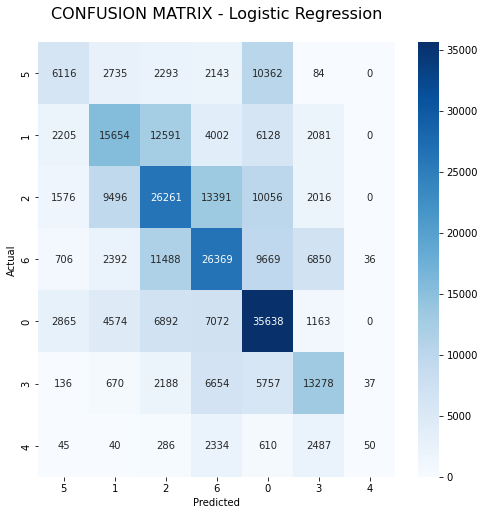

In [ ]:
conf_mat = confusion_matrix(y_test, LR_y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=dataset['Composer'].unique(), 
            yticklabels=dataset['Composer'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Logistic Regression\n", size=16);


In [ ]:
# saving models
import pickle
DIR = "./drive/MyDrive/MLProject/Dataset/Models/"

# LOGISTIC REGRESSION
LR_pickle = "%sLR_model.pkl" % Model_DIR

with open(LR_pickle, 'wb') as file:
    pickle.dump(LR_pipeline, file)

In [ ]:
# Linear SVC
# This method uses one vs rest stretegy

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

LSVC_pipeline = make_pipeline(MinMaxScaler(), LinearSVC(multi_class='ovr', max_iter=2000))
LSVC_pipeline.fit(x_train[:100000], y_train[:100000])

print("""
Takes too much time
while reading on internet I found out SVC uses
libsvc which is slow, and then recommanded to use
use liblinear (linear kernel) which in my I case I was using 
which was so very slow.

https://datascience.stackexchange.com/questions/57863/why-my-svm-svc-fit-linear-kernal-run-so-long-time
""")


Takes too much time
while reading on internet I found out SVC uses
libsvc which is slow, and then recommanded to use
use liblinear (linear kernel) which in my I case I was using 
which was so very slow.

https://datascience.stackexchange.com/questions/57863/why-my-svm-svc-fit-linear-kernal-run-so-long-time



In [ ]:
LSVC_y_pred = LSVC_pipeline.predict(x_test[:10000])

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix

LSVC_test_r2 = r2_score(y_test[:10000], LSVC_y_pred)
# KNN_train_r2 = r2_score(y_train, KNN_y_train_pred)

LSVC_test_mse = mean_squared_error(y_test[:10000], LSVC_y_pred)
# KNN_train_mse = mean_squared_error(y_train, KNN_y_train_pred)

LSVC_test_accuracy = accuracy_score(y_test[:10000], LSVC_y_pred)
# KNN_train_accuracy = accuracy_score(y_train, KNN_y_train_pred)

print("Test r2_score for LSVC %.2f" % LSVC_test_r2)
# print("Train r2_score %.2f" % KNN_train_r2)

print("\nTest mean squared error for LSVC %.2f" % LSVC_test_mse)
# print("Train mean squared error %.2f" % KNN_train_mse)

print("\nTest accuracy score for LSVC %.2f" % LSVC_test_accuracy)
# print("Train accuracy score %.2f" % KNN_train_accuracy)

Test r2_score for LSVC -0.08

Test mean squared error for LSVC 2.48

Test accuracy score for LSVC 0.44


In [ ]:
print("Classificaion report")
print(classification_report(y_test[:10000], LSVC_y_pred))

Classificaion report
              precision    recall  f1-score   support

           0       0.46      0.19      0.26       831
           1       0.45      0.41      0.42      1505
           2       0.46      0.39      0.42      2313
           3       0.42      0.46      0.44      2018
           4       0.45      0.66      0.54      2092
           5       0.46      0.46      0.46      1025
           6       0.00      0.00      0.00       216

    accuracy                           0.44     10000
   macro avg       0.38      0.37      0.36     10000
weighted avg       0.44      0.44      0.43     10000



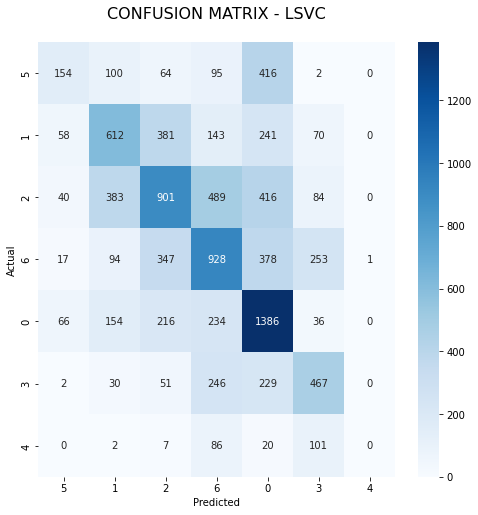

In [ ]:
conf_mat = confusion_matrix(y_test[:10000], LSVC_y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=dataset['Composer'].unique(), 
            yticklabels=dataset['Composer'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LSVC\n", size=16);

In [ ]:
# saving model
import pickle
DIR = "./drive/MyDrive/MLProject/Dataset/Models/"

# KNN
LSVC_pickle = "%sLSVC_model.pkl" % Model_DIR

with open(LSVC_pickle, 'wb') as file:
    pickle.dump(LSVC_pipeline, file)

In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

KNN_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())
KNN_pipeline.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
# Predictions
KNN_y_pred = KNN_pipeline.predict(x_test)

# due to very large dataset this is taking more than 2 hours
#KNN_y_train_pred = KNN_pipeline.predict(x_train)

In [ ]:
# calculating other require values
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix

KNN_test_r2 = r2_score(y_test, KNN_y_pred)
# KNN_train_r2 = r2_score(y_train, KNN_y_train_pred)

KNN_test_mse = mean_squared_error(y_test, KNN_y_pred)
# KNN_train_mse = mean_squared_error(y_train, KNN_y_train_pred)

KNN_test_accuracy = accuracy_score(y_test, KNN_y_pred)
# KNN_train_accuracy = accuracy_score(y_train, KNN_y_train_pred)

print("Test r2_score for KNN %.2f" % KNN_test_r2)
# print("Train r2_score %.2f" % KNN_train_r2)

print("\nTest mean squared error for KNN %.2f" % KNN_test_mse)
# print("Train mean squared error %.2f" % KNN_train_mse)

print("\nTest accuracy score for KNN %.2f" % KNN_test_accuracy)
# print("Train accuracy score %.2f" % KNN_train_accuracy)

Test r2_score for KNN 0.75

Test mean squared error for KNN 0.58

Test accuracy score for KNN 0.88


In [ ]:
print("Classificaion report")
print(classification_report(y_test, KNN_y_pred))

Classificaion report
              precision    recall  f1-score   support

           0       0.86      0.89      0.88     23733
           1       0.90      0.91      0.91     42661
           2       0.88      0.89      0.88     62796
           3       0.87      0.89      0.88     57510
           4       0.89      0.87      0.88     58204
           5       0.85      0.84      0.85     28720
           6       0.90      0.65      0.76      5852

    accuracy                           0.88    279476
   macro avg       0.88      0.85      0.86    279476
weighted avg       0.88      0.88      0.88    279476



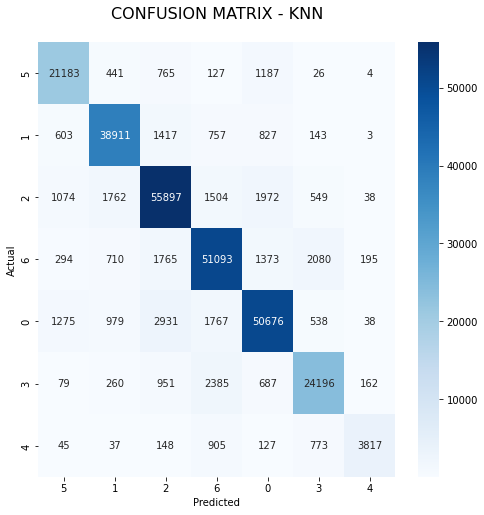

In [ ]:
conf_mat = confusion_matrix(y_test, KNN_y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=dataset['Composer'].unique(), 
            yticklabels=dataset['Composer'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - KNN\n", size=16);

In [ ]:
# saving model
import pickle
DIR = "./drive/MyDrive/MLProject/Dataset/Models/"

# KNN
KNN_pickle = "%sKNN_model.pkl" % Model_DIR

with open(KNN_pickle, 'wb') as file:
    pickle.dump(KNN_pipeline, file)

In [ ]:
# Multinominal naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, Coun

MNB_pipeline = make_pipeline(MinMaxScaler(), MultinomialNB())
MNB_pipeline.fit(x_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('multinomialnb', MultinomialNB())])

In [ ]:
MNB_y_pred = MNB_pipeline.predict(x_test)
MNB_y_train_pred = MNB_pipeline.predict(x_train)

In [ ]:
# calculating other require values
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix

MNB_test_r2 = r2_score(y_test, MNB_y_pred)
MNB_train_r2 = r2_score(y_train, MNB_y_train_pred)

MNB_test_mse = mean_squared_error(y_test, MNB_y_pred)
MNB_train_mse = mean_squared_error(y_train, MNB_y_train_pred)

MNB_test_accuracy = accuracy_score(y_test, MNB_y_pred)
MNB_train_accuracy = accuracy_score(y_train, MNB_y_train_pred)

print("Test r2_score %.2f" % MNB_test_r2)
print("Train r2_score %.2f" % MNB_train_r2)

print("\nTest mean squared error %.2f" % MNB_test_mse)
print("Train mean squared error %.2f" % MNB_train_mse)

print("\nTest accuracy score %.2f" % MNB_test_accuracy)
print("Train accuracy score %.2f" % MNB_train_accuracy)

Test r2_score -0.21
Train r2_score -0.21

Test mean squared error 2.79
Train mean squared error 2.78

Test accuracy score 0.22
Train accuracy score 0.22


In [ ]:
print("Classificaion report")
print(classification_report(y_test, MNB_y_pred))

Classificaion report


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     23733
           1       0.00      0.00      0.00     42661
           2       0.22      1.00      0.37     62796
           3       1.00      0.00      0.00     57510
           4       0.00      0.00      0.00     58204
           5       0.00      0.00      0.00     28720
           6       0.00      0.00      0.00      5852

    accuracy                           0.22    279476
   macro avg       0.17      0.14      0.05    279476
weighted avg       0.26      0.22      0.08    279476



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


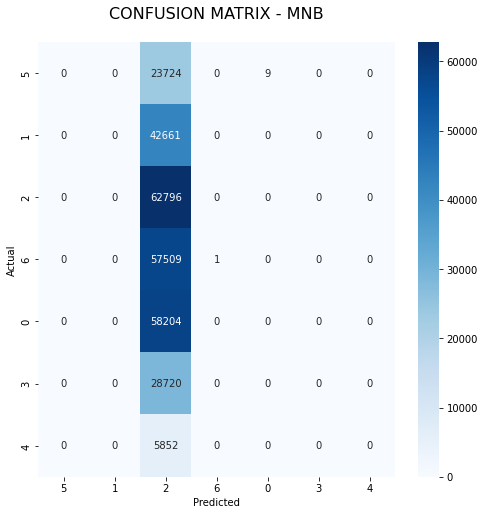

In [ ]:
conf_mat = confusion_matrix(y_test, MNB_y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=dataset['Composer'].unique(), 
            yticklabels=dataset['Composer'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - MNB\n", size=16);

In [ ]:
# saving model
import pickle
DIR = "./drive/MyDrive/MLProject/Dataset/Models/"

# KNN
MNB_pickle = "%sMNB_model.pkl" % Model_DIR

with open(MNB_pickle, 'wb') as file:
    pickle.dump(MNB_pipeline, file)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

RDC_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
RDC_pipeline.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
RDC_y_pred = RDC_pipeline.predict(x_test)
RDC_y_train_pred = RDC_pipeline.predict(x_train)

In [ ]:
# calculating other require values
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix

RDC_test_r2 = r2_score(y_test, RDC_y_pred)
RDC_train_r2 = r2_score(y_train, RDC_y_train_pred)

RDC_test_mse = mean_squared_error(y_test, RDC_y_pred)
RDC_train_mse = mean_squared_error(y_train, RDC_y_train_pred)

RDC_test_accuracy = accuracy_score(y_test, RDC_y_pred)
RDC_train_accuracy = accuracy_score(y_train, RDC_y_train_pred)

print("Test r2_score %.2f" % RDC_test_r2)
print("Train r2_score %.2f" % RDC_train_r2)

print("\nTest mean squared error %.2f" % RDC_test_mse)
print("Train mean squared error %.2f" % RDC_train_mse)

print("\nTest accuracy score %.2f" % RDC_test_accuracy)
print("Train accuracy score %.2f" % RDC_train_accuracy)

Test r2_score 0.65
Train r2_score 1.00

Test mean squared error 0.81
Train mean squared error 0.00

Test accuracy score 0.83
Train accuracy score 1.00


In [ ]:
print("Classificaion report")
print(classification_report(y_test, RDC_y_pred))

Classificaion report
              precision    recall  f1-score   support

           0       0.88      0.82      0.85     23733
           1       0.89      0.84      0.87     42661
           2       0.82      0.84      0.83     62796
           3       0.81      0.84      0.82     57510
           4       0.81      0.85      0.83     58204
           5       0.78      0.79      0.78     28720
           6       0.96      0.41      0.57      5852

    accuracy                           0.83    279476
   macro avg       0.85      0.77      0.79    279476
weighted avg       0.83      0.83      0.83    279476



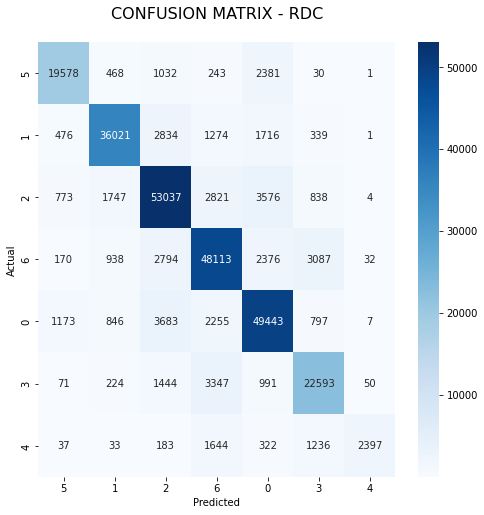

In [ ]:
conf_mat = confusion_matrix(y_test, RDC_y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=dataset['Composer'].unique(), 
            yticklabels=dataset['Composer'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - RDC\n", size=16);

In [ ]:
# saving model
import pickle

# KNN
RDC_pickle = "%sRDC_model.pkl" % Model_DIR

with open(RDC_pickle, 'wb') as file:
    pickle.dump(RDC_pipeline, file)

In [ ]:
# loading all models
DIR = "./drive/MyDrive/MLProject/Dataset/Models/"

import pickle 

LR_pickle = "%sLR_model.pkl" % Model_DIR
MNB_pickle = "%sMNB_model.pkl" % Model_DIR
KNN_pickle = "%sKNN_model.pkl" % Model_DIR
RDC_pickle = "%sRDC_model.pkl" % Model_DIR
LSVC_pickle = "%sLSVC_model.pkl" % Model_DIR

with open(LR_pickle, 'rb') as file:
    LR_pipeline = pickle.load(file)

with open(MNB_pickle, 'rb') as file:
    MNB_pipeline = pickle.load(file)

with open(KNN_pickle, 'rb') as file:
    KNN_pipeline = pickle.load(file)

with open(RDC_pickle, 'rb') as file:
    RDC_pipeline = pickle.load(file)

with open(LSVC_pickle, 'rb') as file:
    LSVC_pipeline = pickle.load(file)

## Comparing models with each other
1. Logistic regression
2. KNN
3. Multinomial Naive bayes
4. Random Forest

### Making dataset of f1_score, precision, recall, r2_score, accuracy for each model

In [ ]:
model_names = [ "Logistic Regression", "K Nearest Neighbour", "Multinomial Naive Bayes", "Random Forest Classifier", "Linear SVM" ]
models = [LR_pipeline, KNN_pipeline, MNB_pipeline, RDC_pipeline, LSVC_pipeline]

In [ ]:
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, auc, f1_score

r2_scores = []
accuracies = []
precisions = []
recalls = []
aucs = []
f1_scores = []

for idx, (name, model) in enumerate(zip(model_names, models)):
    y_pred = model.predict(x_test)

    r2_scores.append   ( r2_score        (y_test, y_pred) )
    accuracies.append  ( accuracy_score  (y_test, y_pred) )
    f1_scores.append   ( f1_score        (y_test, y_pred, average='weighted') )
    precisions.append  ( precision_score (y_test, y_pred, average='weighted') )
    recalls.append     ( recall_score    (y_test, y_pred, average='weighted') )
    
    print(f"Model: {name}")

Model: Logistic Regression
Model: K Nearest Neighbour


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Multinomial Naive Bayes
Model: Random Forest Classifier
Model: Linear SVM


In [ ]:
score_dict = {
    "MLA": model_names,
    "r2_score": r2_scores,
    "accuracy": accuracies,
    "precision": precisions,
    "recall": recalls,
    'f1_score': f1_scores
}

model_df = pd.DataFrame.from_dict(score_dict)

model_df.to_csv("./drive/MyDrive/MLProject/Dataset/model_df.csv")

In [ ]:
model_df = pd.read_csv("./drive/MyDrive/MLProject/Dataset/model_df.csv")
model_df.head()

,Unnamed: 0,MLA,r2_score,accuracy,precision,recall,f1_score
0,0,Logistic Regression,-0.072119,0.441419,0.440190,0.441419,0.431588
1,1,K Nearest Neighbour,0.749640,0.879406,0.879579,0.879406,0.879005
2,2,Multinomial Naive Bayes,-0.207171,0.224696,0.256266,0.224696,0.082457
3,3,Random Forest Classifier,0.648737,0.827198,0.830078,0.827198,0.825929
4,4,Linear SVM,-0.099718,0.438020,0.429364,0.438020,0.424056


### Accuracy of each model

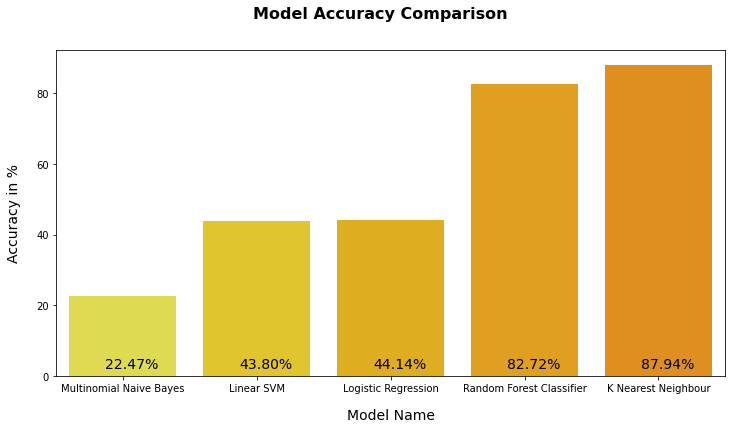

In [ ]:
plt.figure(figsize=(12, 6))

sns.barplot(
    x=model_df['MLA'], 
    y=(model_df['accuracy']*100),
    palette="Wistia",
    order=model_df.sort_values('accuracy').MLA
)

for idx, acc in enumerate( model_df.sort_values('accuracy')['accuracy'] ):
    text = '%.2f%%' % (acc * 100)
    plt.text((idx - 0.13), 2, text, fontsize=14)

plt.suptitle("Model Accuracy Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Model Name", labelpad=15, fontsize=14)
plt.ylabel("Accuracy in %", labelpad=15, fontsize=14)
plt.show()

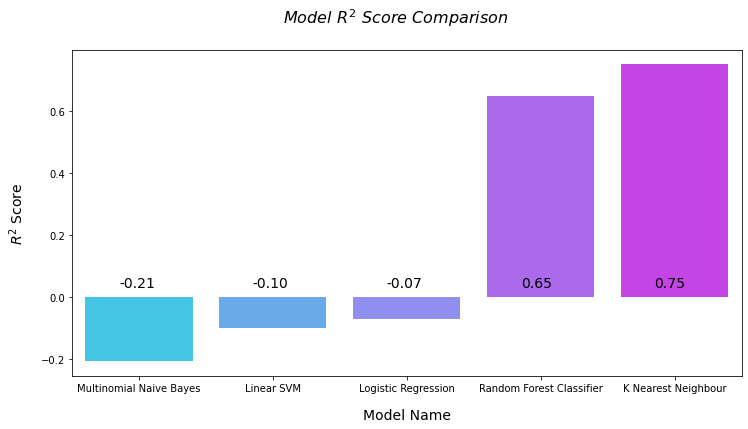

In [ ]:
plt.figure(figsize=(12, 6))

sns.barplot(
    x=model_df['MLA'], 
    y=model_df['r2_score'],
    palette="cool",
    order=model_df.sort_values('r2_score').MLA
)

for idx, r2 in enumerate( model_df.sort_values('r2_score')['r2_score'] ):
    text = '%.2f' % r2
    plt.text((idx - 0.15), 0.03, text, fontsize=14)

plt.suptitle("$Model\ R^2\ Score\ Comparison$", fontsize=16, fontweight='bold')
plt.xlabel("Model Name", labelpad=15, fontsize=14)
plt.ylabel("$R^2$ Score", labelpad=15, fontsize=14)
plt.show()

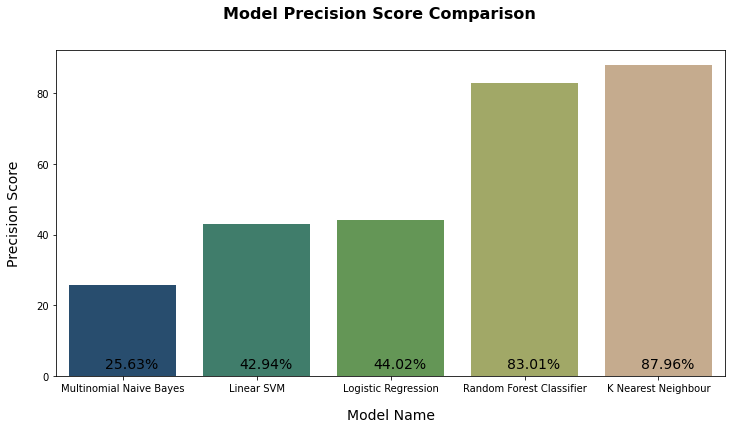

In [ ]:
plt.figure(figsize=(12, 6))

sns.barplot(
    x=model_df['MLA'], 
    y=model_df['precision'] * 100,
    palette="gist_earth",
    order=model_df.sort_values('precision').MLA
)

for idx, p in enumerate( model_df.sort_values('precision')['precision'] ):
    text = '%.2f%%' % (p * 100)
    plt.text((idx - 0.13), 2, text, fontsize=14)

plt.suptitle("Model Precision Score Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Model Name", labelpad=15, fontsize=14)
plt.ylabel("Precision Score", labelpad=15, fontsize=14)
plt.show()

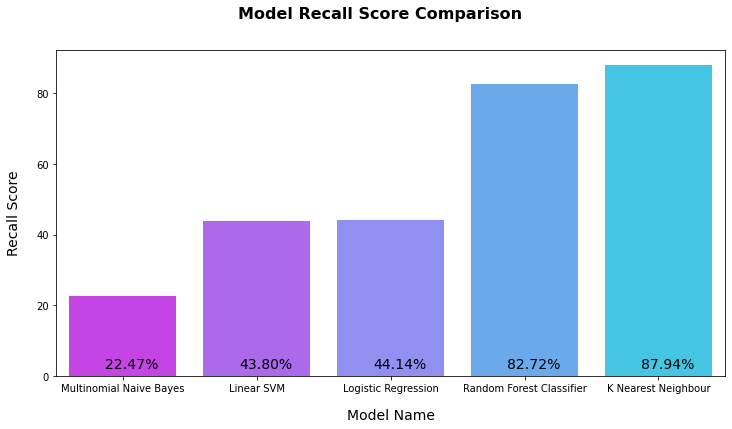

In [ ]:
plt.figure(figsize=(12, 6))

sns.barplot(
    x=model_df['MLA'], 
    y=model_df['recall'] * 100,
    palette="cool_r",
    order=model_df.sort_values('recall').MLA
)

for idx, p in enumerate( model_df.sort_values('recall')['recall'] ):
    text = '%.2f%%' % (p * 100)
    plt.text((idx - 0.13), 2, text, fontsize=14)

plt.suptitle("Model Recall Score Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Model Name", labelpad=15, fontsize=14)
plt.ylabel("Recall Score", labelpad=15, fontsize=14)
plt.show()

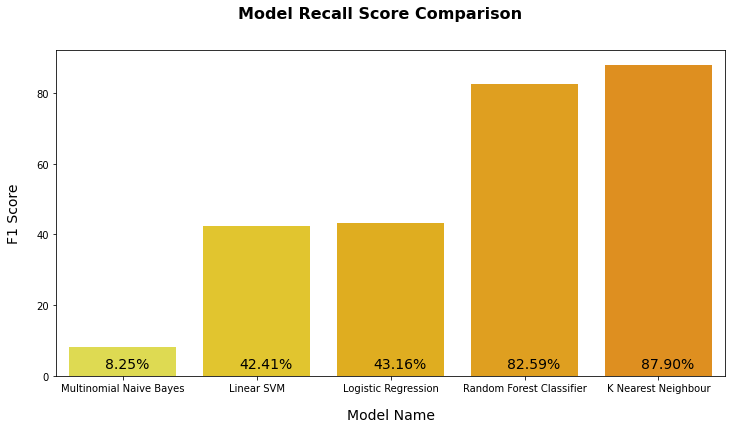

In [ ]:
plt.figure(figsize=(12, 6))

sns.barplot(
    x=model_df['MLA'], 
    y=model_df['f1_score'] * 100,
    palette="Wistia",
    order=model_df.sort_values('f1_score').MLA
)

for idx, p in enumerate( model_df.sort_values('f1_score')['f1_score'] ):
    text = '%.2f%%' % (p * 100)
    plt.text((idx - 0.13), 2, text, fontsize=14)

plt.suptitle("Model Recall Score Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Model Name", labelpad=15, fontsize=14)
plt.ylabel("F1 Score", labelpad=15, fontsize=14)
plt.show()